# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

# formula api vs. array-based
import statsmodels.formula.api as smf

# panel OLS for sanity check
from linearmodels.panel import PanelOLS

# contrasts for sanity check
from patsy.contrasts import Treatment

import warnings

# Project Summary


**Question** Does liberalizing divorce law affect national income inequality (Gini index)?

Design: I analyze a global country–year panel using staggered difference-in-differences (DiD) with country and year fixed effects. Treatment is the first year a country adopts no-fault divorce (see Treatment Coding). The outcome is the national Gini index. Because countries adopt in different years, later adopters can serve as controls for earlier adopters (and vice versa), identifying dynamic post-reform effects under standard DiD assumptions (parallel trends and no anticipation).

Data Structure: The data are observational. Unlike a randomized controlled trial, there is no constructed counterfactual. I do not use propensity-score matching or synthetic controls because, at the country level, common support is thin and the donor pool at each adoption time is limited; strong cross-country heterogeneity further undermines those designs.

Interpretation: I describe effects as causal under assumptions. The mechanism is plausible—divorce law materially changes household formation and bargaining power—and the staggered global timing provides useful contrasts. Still, identification relies on the DiD assumptions rather than on experimental assignment.

Scope: By analyzing many countries, I leverage heterogeneity to reduce idiosyncratic parallel-trend violations, aiming to focus causal identification on the divorce law reform, rather than unrelated confounders. This is not a guarantee of identification, but complements the fixed effects structure.


**Difference-in-Differences - Two Approaches**

In observational data, countries adopt reforms at different calendar years, so there is no single “treatment time” as there would be in a controlled trial. Two natural designs for this type of data are:

1. Country-by-country 2×2 DiD (each country as its own two-period, two-group comparison)
2. Staggered adoption designs (multiple units and periods with different adoption years)

The per-country 2×2 design is not feasible here, as treatment status and outcomes are national aggregates. I do not have municipal or county-level data, which would be required for a 2x2 DiD. 

For the staggered design, I follow guidance in Baker, Callaway, Cunningham, Goodman-Bacon, and Sant’Anna (2025), *Difference-in-Differences Designs: A Practitioner’s Guide* (arXiv:2503.13323). https://arxiv.org/pdf/2503.13323

I implement two staggered strategies:


**I. Cohort Approach**

I group countries into per-decade cohorts, according to the decade in which divorce law reform occurred. Each cohort’s “event time” is anchored at the cohort’s modal adoption year, and I estimate a TWFE regression within each cohort.

Unfortunately, binning countries into cohorts leads to data contamination, both in controls and treated groups. 

Controls may include already-treated countries (if a country’s true reform was before the cohort modal year), and treated-post may include not-yet-treated countries (if a country’s true reform was after the cohort modal year). Given that legal and social changes evolve gradually, limited within-decade contamination may be acceptable, but is clearly less than ideal.

**II. Event-Study Approach**

Rather than focus on calendar years, I evaluate pre and post groups in terms of relative time-distance from the treatment year. This avoids contamination because no treated-post-treatment country is ever included in controls, and no untreated country is ever included in treated-post-treatment. 

While avoiding contamination, the event study approach over long time periods strains credulity. For example, taking an event study approach requires that I superimpose, say, 1975 onto 1995, as if there were no salient differences between those two time periods.

However, if countries do in fact tend to change some time after treatment, which is the essence of the question at hand, this would surely be identified in an event study. A practical and ecumenical approach might be to conduct an event study for each decade cohort, which may be the next step I take in this project.


**Inference**

I use frequentist inference (t-tests and p-values from statsmodels) with a typical alpha of 0.05.


**Treatment Coding**

Divorce regimes vary in restrictiveness, in order of most restrictive to most liberal:

1. Illegal
2. Fault-based only (no “irreconcilable differences”)
3. No-fault (lite/mutual): breakdown recognized but may require proof, separation periods, or mutual consent
4. No-fault (unilateral): one party’s assertion suffices, no proof needed

For analysis, I collapse the above four categories into two groups:

Group I ("never treated"): No recognition of “irretrievable breakdown/irreconcilable differences,” or procedures that are substantively one-sided/unfair (1 & 2 above)

Group II (treated or not-yet-treated): No-fault permitted, including recognition of irretrievable breakdown/irreconcilable differences (3 & 4 above)


# Causal Mechanism

This study is causal because of the putative causal mechanism at play.

Historically, marriage has been an arrangement in which women have little power or agency. 

Women still do the majority of housework even in dual income households (domestic labor such as cooking, cleaning, tidying, calendar management). In time use studies, researchers have found that only divorced men do an equal share of housework, by necessity (Lockman, D. (2019). All the rage: Mothers, fathers, and the myth of equal partnership. HarperCollins.)

When divorce laws are liberalized, women become empowered to exit marriages. In the aftermath of divorce, household structures change. Men must either do the housework for themselves, or pay for services like housekeeping and food preparation. The people who tend to do these jobs are women.

Therefore, it is at least plausible that divorce leads to greater income equality, by forcing men to pay for work, which was previously done by their wives unpaid.

This analysis attempts to identify whether significant changes in income equality (as measured by Gini Index) occured following the passage of divorce laws. 

## DAG
U (norms, development)
   ↘              ↘
    → Divorce law liberalization → Divorce / exit option → Household structure (separate households)
                                                     → Household bargaining / time allocation
                                                     → Female labor supply / earnings
                                                     → Income inequality

# Background and Dependencies

This study complements my parallel project, **CoResidence Analysis** (repo: https://github.com/LittleBiggler/CoResidence)

Exploratory visuals from that work show several features with inflection points in the 1970s–1980s and broad shifts toward households that are (1) smaller and (2) more often female-headed. During this period, the share of unipersonal households rose, share of female-headed households rose (versus male-headed), average number of children per household fell, and age of inhabitants increased. If household configuration relates to inequality, *something important* appears to change in the 1970s–1980s.


**Gini Handling** 

Where annual values were missing, I imputed the Gini series. Prior to imputation, I inverted its scale for interpretability (higher = more equality). All ground-truth data was kept, and only missing data was reconstructed. See the CoResidence project’s “Target Imputation” section for more details.

**Divorce Data**

I compiled no-fault divorce adoption years primarily via Google searches, following links to government sources or (frequently) law-firm explainers aimed at prospective clients. I did not rely on AI overviews. For a fully rigorous legal history, collaboration with legal scholars would be appropriate; for this exploratory study, curated web sources were sufficient. I cross-referenced my findings with an amateur compilation from World Population Review (cited below).

Citations

Baker, Callaway, Cunningham, Goodman-Bacon, and Sant’Anna (2025), Difference-in-Differences Designs: A Practitioner’s Guide (arXiv:2503.13323). https://arxiv.org/pdf/2503.13323

Countries Where Divorce Is Illegal 2025. World Population Review. Retrieved June 19, 2025, from https://worldpopulationreview.com/country-rankings/countries-where-divorce-is-illegal




# CoResidence Data

CoResidence with all merges and imputed targets


In [2]:
# read in data

df_raw = pd.read_csv('./artifact/cores_full_merge.csv')
df_raw.shape

(7750, 155)

In [3]:
df = df_raw.copy()

In [4]:
# take oly the columns neede for gini analysis
# potential to include covariates later

df = df_raw[['Country Name', 'Country Code', 'Year', 'Gini_recon_hybrid', 'Gini','Gini_missing']]

In [5]:
df.shape

(7750, 6)

# Divorce Data

In [6]:
# import original divorce data, compiled by me
divorce_data = pd.read_csv('./divorce_table_final.csv', index_col=0)
divorce_data.head()

,Country,Blame Based,Fault Comment,Irreconcilable Differences,No Fault Comment,Treatment Y/N,Treatment Year,Unnamed: 8,Fault Based,Mutual No Fault,Unilateral No Fault
0,Afghanistan,1977.0,Fault required,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
1,Albania,2003.0,Fault required,2013.0,Favors men,No,NaN,NaN,NaN,NaN,NaN
2,Algeria,1984.0,Fault required,2005.0,Favors men,No,NaN,NaN,NaN,NaN,NaN
3,Angola,NaN,NaN,1975.0,No fault,Yes,1976.0,NaN,Yes,Yes,One year separation
4,Argentina,1987.0,Fault required,2015.0,No fault,Yes,2016.0,NaN,No,Yes,Yes


In [7]:
# convert "Treatment Y/N" to integer

divorce_data['Treatment'] = divorce_data['Treatment Y/N'].map({'Yes':1, 'No':0})

In [8]:
# check if any years are missing from treatment

mask = (divorce_data['Treatment'].eq(1) & divorce_data['Treatment Year'].isnull())
    
if mask.any():  
    print(f"Uh-oh, year missing for {divorce_data.loc[mask, 'Country'].to_list()}")
else:
    print('All good and tidy.')

All good and tidy.


In [9]:
# check if any untreated years have a date in the "Treatment Year" column by accident

mask = (divorce_data['Treatment Y/N']=='No') & (divorce_data['Treatment Year'].notnull())

if mask.any():
    print(f"Uh-oh, year missing for {divorce_data.loc[mask, 'Country'].to_list()}")
else:
    print('All good and tidy.')

All good and tidy.


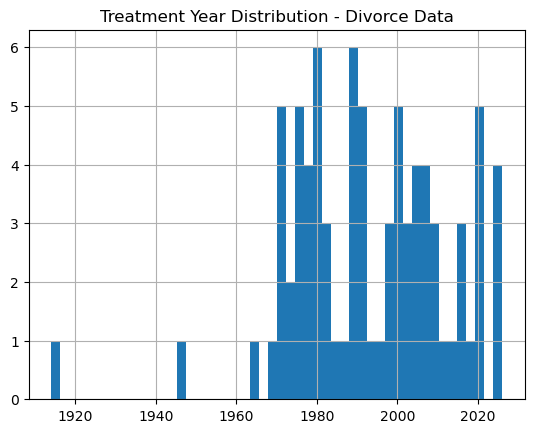

In [10]:
# visualize divorce year

divorce_data['Treatment Year'].hist(bins=50)
plt.title('Treatment Year Distribution - Divorce Data')
plt.show()

# Merge: CoResidence & Divorce Data

In [11]:
# anticipate merge failures

[country for country in df['Country Name'].unique() if country not in divorce_data['Country'].unique()]

['Slovak Republic',
 'Czechia',
 'Egypt, Arab Rep.',
 'Viet Nam',
 'Venezuela, RB',
 'St. Lucia',
 'Congo, Dem. Rep.',
 'Lao PDR',
 'Korea, Rep.',
 'Iran, Islamic Rep.',
 'Turkiye',
 'Russian Federation',
 'West Bank and Gaza',
 'North Macedonia',
 'Yemen, Rep.',
 'Gambia, The']

In [12]:
# name mapper for improved merge:

country_name_mapper = {
    'Congo, Dem. Rep.':'Congo',
 'Czechia':'Czech Republic',
 'Egypt, Arab Rep.':'Egypt',
 'Gambia, The':'Gambia',
 'Iran, Islamic Rep.':'Iran',
 'Korea, Rep.':'South Korea',
 'Lao PDR':'Laos',
 'North Macedonia':'Macedonia',
 'West Bank and Gaza':'Palestine',
 'Russian Federation':'Russia',
 'Slovak Republic':'Slovakia',
 'Venezuela, RB':'Venezuela',
 'Viet Nam':'Vietnam',
 'Yemen, Rep.':'Yemen'
}

# reverse
country_name_mapper = {
    value:key for key, value in country_name_mapper.items()
}


In [13]:
# update names in right table to prepare for successful merge

divorce_data['Country'] = divorce_data['Country'].replace(country_name_mapper)


In [14]:
# left merge with divorce data

df_mstr = df.merge(divorce_data, left_on='Country Name', right_on='Country', how='left')

In [15]:
# drop columns not needed 
columns_to_drop = ['Unnamed: 8', 'Fault Based', 'Mutual No Fault', 'Unilateral No Fault']
df_mstr = df_mstr.drop(columns=columns_to_drop)

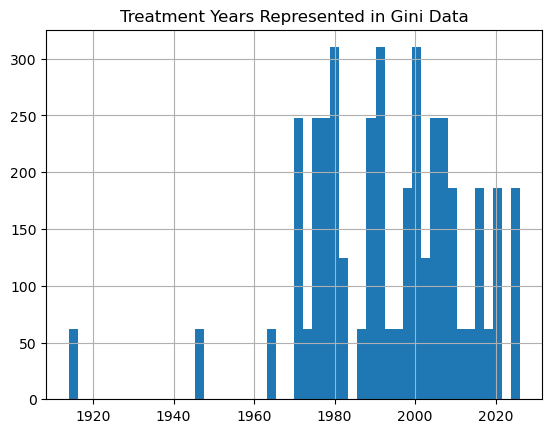

Percentage of observations ever treated: 54.40%


In [16]:
# Plot treatment years represented in merged data

df_mstr['Treatment Year'].hist(bins=50)
plt.title('Treatment Years Represented in Gini Data')
plt.show()

# size of treated vs. not treated, by year
percent_treated = df_mstr['Treatment Year'].notnull().sum()/len(df_mstr)
print(f"Percentage of observations ever treated: {percent_treated*100:.2f}%")

# Data Prep

Prepare the data for DiD-specific requirements, including removing singletons and ensuring that each cohort has at least 30 instances of treated data

In [17]:
print(df_mstr['Country'].nunique())
df_mstr.shape

123


(7750, 14)

In [18]:
# OnTreat column tracks which entities and years have received treatment

df_mstr['OnTreat'] = (
    (df_mstr['Year']>=df_mstr['Treatment Year']) & df_mstr['Treatment'].eq(1)
).astype(int)


In [19]:
# create treatment cohorts

def treatment_cohort(treatment_year):
    """Takes treatment year and assigns to a cohort"""
    if pd.isna(treatment_year):
        return np.nan
    floor_decade = int((treatment_year)//10*10)
    ceiling_decade = floor_decade + 9
    treatment_cohort = f"{floor_decade}-{ceiling_decade}"
    return(treatment_cohort)
    

In [20]:
# create treatment cohorts using formula

df_mstr['Treatment Cohort'] = df_mstr['Treatment Year'].apply(lambda x: treatment_cohort(x))

print(f"Treatment Cohorts: {sorted(df_mstr['Treatment Cohort'].dropna().unique())}")

Treatment Cohorts: ['1910-1919', '1940-1949', '1960-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2019', '2020-2029']


In [21]:
# define viable group as having both pre and post years (when treated)

def group_viability(group):
    """Tests a group for DiD viability"""
    min_t = group['OnTreat'].min()
    max_t = group['OnTreat'].max()

    viable_group_mask = ((min_t==0) & (max_t==1)) | (max_t==0)
    viable_group_mask &= (group['Year'].nunique()>=2)

    viable_groups = viable_group_mask[viable_group_mask].index
    
    return viable_groups

In [22]:
# 
group = df_mstr.groupby('Country')

viable_countries = group_viability(group)
viable_countries

Index(['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria',
       'Bangladesh', 'Belarus', 'Belgium', 'Benin',
       ...
       'Ukraine', 'United Kingdom', 'United States', 'Uzbekistan',
       'Venezuela, RB', 'Viet Nam', 'West Bank and Gaza', 'Yemen, Rep.',
       'Zambia', 'Zimbabwe'],
      dtype='object', name='Country', length=121)

In [23]:
# filter df_mstr down to appropriate countries only
# "singleton" countries are filtered out
# further filtering will be needed by cohort or event time group

#df_mstr = df_mstr[df_mstr['Country'].isin(viable_countries)]
df_mstr.shape

(7750, 16)

### df_mstr change log

df_mstr has gone through preliminary preparatory steps to ensure best outcomes in the varying DiD approaches that follow. Further filtering may be needed to ensure that event time requirements are met.

For now, the following changes were made to **df_mstr** vs. raw data, after the left merge with divorce data:

1) OnTreat column created
2) Singleton treated countries filtered out
3) Treatment cohort column created

Singleton countries are countries lacking in either intra-unit or time variation. In other words, treated countries that lack a pre-treatment year, or never-treated countries with less than two years of data. Without variation, no difference in difference can be calculated. These countries have been filtered out using a function written for the purpose: **group_viability()**


## Cohort Study with smf.OLS()

In [24]:
# create a copy of the master data 

df_did = df_mstr.copy()

In [25]:
# countries per cohort

df_did.groupby('Treatment Cohort').agg(count = ('Country', 'nunique'))

,count
Treatment Cohort,
1910-1919,1
1940-1949,1
1960-1969,1
1970-1979,14
1980-1989,9
1990-1999,12
2000-2009,17
2010-2019,7
2020-2029,6


In [26]:
# define viable cohort to avoid 

group = df_did.groupby('Treatment Cohort')

viable_cohorts = group_viability(group)
viable_cohorts

Index(['1960-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009',
       '2010-2019', '2020-2029'],
      dtype='object', name='Treatment Cohort')

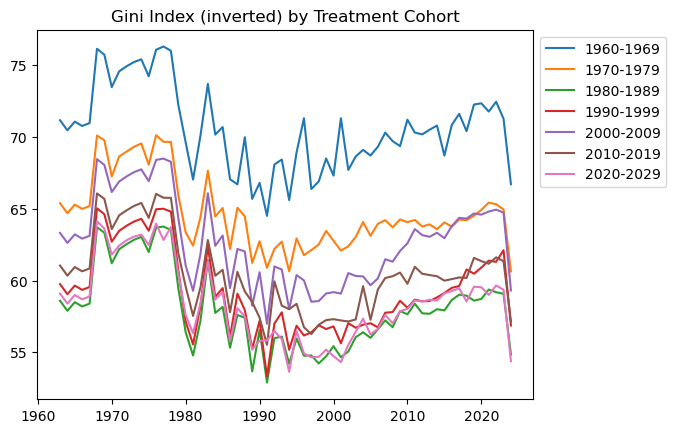

In [27]:
# visualize cohort trends

fig, ax = plt.subplots()

for cohort in viable_cohorts:
    
    annual_agg = (
        df_mstr[df_mstr['Treatment Cohort']==cohort]
        .groupby('Year', as_index=False).agg(Annual_Gini=('Gini_recon_hybrid', 'mean'))
    )
    x_axis = annual_agg['Year']
    y_axis = annual_agg['Annual_Gini']

    plt.plot(x_axis, y_axis, label = cohort)
    plt.legend(bbox_to_anchor=(1,1))

plt.title("Gini Index (inverted) by Treatment Cohort")
plt.show()

In [28]:
# DiD

# initiate dictionaries to store results
results = {}
warn_log = {}
custom_summary = []

Y = 'Gini_recon_hybrid'
target = 'Treatment:OnTreat'

for cohort in viable_cohorts:
    print(cohort)
    treated_mask = df_did['Treatment Cohort']==cohort #all cohorts by definition are treated
    treated = df_did[treated_mask]

    benchmark_year = treated['Treatment Year'].mode().iat[0] #treatment year per cohort
    
    # control groups:
    # never treated & not-yet-treated (where years come before treatment)
    never_treated_mask = df_did['Treatment']== 0
    not_yet_treated_mask = (df_did['Treatment Year'].gt(benchmark_year) 
                            & df_did['Year'].lt(df_did['Treatment Year']))
    control_mask = never_treated_mask | not_yet_treated_mask
                            
    subset = df_did.loc[treated_mask | control_mask].copy()
    
    # identify countries with fewer than 2 observations
    singleton_countries = subset['Country'].value_counts().loc[lambda x: x<2]
    print(cohort, singleton_countries)
    
    # drop singleton countries
    subset = subset[~subset['Country'].isin(singleton_countries)].copy()
    
    # DiD formula
    formula = f"{Y} ~ Treatment:OnTreat + C(Year) + C(Country)"
    
    

    result = smf.ols(formula=formula, data=subset).fit(
    cov_type = 'cluster',
    cov_kwds = {'groups': subset['Country']})
        

    
    # collect results in dictionary
    results[cohort] = result

    # generate DiD stats
    coef = result.params.get(target, np.nan)
    se = result.bse.get(target, np.nan)
    tval = result.tvalues.get(target, np.nan)
    pval = result.pvalues.get(target, np.nan)
    
    if (not np.isfinite(se)) or (se==0):
        warn_log.setdefault(cohort, []).append(
            f"SE invalid (se={se}); clusters={subset['Country'].nunique()}"
        )
        
    # gather DiD stats
    custom_summary.append({
        "cohort" : cohort,
        "coef": coef,
        "se":se,
        "tval": tval,
        "pval": pval
    }
    )

1960-1969
1960-1969 Series([], Name: Country, dtype: int64)
1970-1979
1970-1979 Series([], Name: Country, dtype: int64)


/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


1980-1989
1980-1989 Series([], Name: Country, dtype: int64)
1990-1999
1990-1999 Series([], Name: Country, dtype: int64)


/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


2000-2009
2000-2009 Series([], Name: Country, dtype: int64)
2010-2019
2010-2019 Series([], Name: Country, dtype: int64)
2020-2029
2020-2029 Series([], Name: Country, dtype: int64)


/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


In [29]:
# inspect custom summary
custom_summary = pd.DataFrame(custom_summary)
custom_summary

,cohort,coef,se,tval,pval
0,1960-1969,-0.015804,0.038796,-0.407368,0.683738
1,1970-1979,0.234441,0.125353,1.870248,0.061449
2,1980-1989,0.112310,0.061409,1.828873,0.067419
3,1990-1999,0.134515,0.191372,0.702900,0.482118
4,2000-2009,0.347347,0.283688,1.224397,0.220802
5,2010-2019,-0.641509,1.203545,-0.533016,0.594022
6,2020-2029,-0.163125,0.226727,-0.719475,0.471848


In [30]:
# inspect warnings for DiD term
warn_log

{}

## Cohort with PanelOLS

In [31]:
# create a copy
df_panel = df_did.copy()


In [32]:
# set index as required by panel ols
df_panel = df_panel.set_index(['Country', 'Year'])

In [33]:
# try with panel ols

panel_results = {}
panel_summary = []

for cohort in viable_cohorts:
    print(cohort)
    
    benchmark_year = df_panel.loc[df_panel['Treatment Cohort']==cohort, 'Treatment Year'].mode().iat[0]
    print(benchmark_year)
    
    treated_mask = df_panel['Treatment Cohort'] == cohort
    
    never_treated_mask = df_panel['Treatment'] == 0
    not_yet_treated_mask = (
        (df_panel['Treatment Year'] > benchmark_year) & 
        (df_panel.index.get_level_values('Year') < df_panel['Treatment Year'])
    )
    
    control_mask = never_treated_mask | not_yet_treated_mask
    
    es_cols = ['OnTreat']
    
    subset = df_panel.loc[treated_mask | control_mask, es_cols]
    
    y = df_panel.loc[subset.index, 'Gini_recon_hybrid']
    X = subset.copy()
    
    model = PanelOLS(y, X, entity_effects=True, time_effects=True)
    result = model.fit(cov_type='clustered', cluster_entity=True, cluster_time=False)
    
    panel_results[cohort] = result
    
    # build custom summary
    panel_summary.append(
        {
        'cohort_':cohort,
        'coefficient': result.params.iat[0],
        'standard error': result.std_errors.iat[0],
        'p_value': result.pvalues.iat[0],
        't_value': result.tstats.iat[0]
    }
    )
    

1960-1969
1965.0
1970-1979
1977.0
1980-1989
1980.0
1990-1999
1992.0
2000-2009
2001.0
2010-2019
2016.0
2020-2029
2021.0


In [34]:
panel_summary = pd.DataFrame(panel_summary)

panel_summary

,cohort_,coefficient,standard error,p_value,t_value
0,1960-1969,-0.015804,0.038639,0.682537,-0.409026
1,1970-1979,0.234441,0.124840,0.060437,1.877939
2,1980-1989,0.112310,0.061124,0.066204,1.837401
3,1990-1999,0.134515,0.190400,0.479915,0.706489
4,2000-2009,0.347347,0.282042,0.218177,1.231545
5,2010-2019,-0.641509,1.194805,0.591356,-0.536915
6,2020-2029,-0.163125,0.224891,0.468284,-0.725350


In [35]:
side_by_side = pd.DataFrame(pd.concat([custom_summary, panel_summary], axis=1))
side_by_side

,cohort,coef,se,tval,pval,cohort_,coefficient,standard error,p_value,t_value
0,1960-1969,-0.015804,0.038796,-0.407368,0.683738,1960-1969,-0.015804,0.038639,0.682537,-0.409026
1,1970-1979,0.234441,0.125353,1.870248,0.061449,1970-1979,0.234441,0.124840,0.060437,1.877939
2,1980-1989,0.112310,0.061409,1.828873,0.067419,1980-1989,0.112310,0.061124,0.066204,1.837401
3,1990-1999,0.134515,0.191372,0.702900,0.482118,1990-1999,0.134515,0.190400,0.479915,0.706489
4,2000-2009,0.347347,0.283688,1.224397,0.220802,2000-2009,0.347347,0.282042,0.218177,1.231545
5,2010-2019,-0.641509,1.203545,-0.533016,0.594022,2010-2019,-0.641509,1.194805,0.591356,-0.536915
6,2020-2029,-0.163125,0.226727,-0.719475,0.471848,2020-2029,-0.163125,0.224891,0.468284,-0.725350


In [36]:
# extract significant cohorts

alpha = .05
significant_cohorts = side_by_side[side_by_side['pval']<=alpha]
cohort_table = significant_cohorts[['cohort', 'coefficient', 'standard error', 'p_value', 't_value']]


cohort_table_rounded = cohort_table.round(3)
cohort_table_rounded.to_csv("artifact/cohort_table_rounded.csv", index=False)
print(cohort_table_rounded.to_markdown(index=False))

| cohort   | coefficient   | standard error   | p_value   | t_value   |
|----------|---------------|------------------|-----------|-----------|


## Summary

No cohorts had statistically significant results. 1970-1979 had marginal results. 

# Event Study - Manual ATT

I calculate the average treatment effect on the treated (ATT) manually and directly, with boostrapped CI's, for full visibility. (This project is a learning opportunity for me, and I treat the manual ATT calculation as a deep dive to develop solid intuition.)

In [37]:
# copy mstr df and create relative year column

df_es = df_mstr.copy()



In [38]:
# create a "relative year" column for observations and bin the tails

df_es['rel_year'] = (df_es['Year'] - df_es['Treatment Year'])


In [39]:
# assess viability per e

group = df_es.groupby('rel_year')

viable_relyears = group_viability(group)

# all pre-years viable

In [40]:
# plot ATT per e

cell_dict = []
countries = viable_countries

for country in countries:
    # treatment year in calendar time
    Gi = df_es.loc[df_es['Country']==country, 'Treatment Year'].iat[0]
    
    # tzero is e = -1 (baseline year)
    t_0 = Gi - 1
    
    # treated units at tzero (baseline)
    treated_t0_mask = ((df_es['Treatment']==1) & (df_es['Country']==country) & (df_es['Year']==t_0))
    
    s_t0 = df_es.loc[treated_t0_mask, 'Gini_recon_hybrid']
    treated_t0 = s_t0.iat[0] if s_t0.notna().any() else np.nan
    print(country, treated_t0)
    
    # control units at tzero (baseline)
    control_t0_mask = (
            (df_es['Year']==t_0) &
            ((df_es['Treatment']==0) | ((df_es['Treatment']==1) & (df_es['Treatment Year'] > t_0))) & #NT & NYT
            (df_es['Country']!= country) & #control for country FE
            (df_es['Treatment Year']!= Gi) #control for year FE
        )

    s_t0 = df_es.loc[control_t0_mask, 'Gini_recon_hybrid']
    control_t0 = s_t0.mean() if s_t0.notna().any() else np.nan #avg all control units for tzero
        

    # event time list for country in question
    e_list = list(df_es.loc[df_es['Country']==country, 'rel_year'].dropna())

    
    for e in e_list:
        # event time (calendar year for each e)
        t_i = df_es.loc[((df_es['Country']==country) & (df_es['rel_year']==e)), 'Year'].iat[0]

        
        # treated gini value at calendar year corresponding to e
        treated_ti_mask = ((df_es['Treatment']==1) & (df_es['Country']==country) & (df_es['Year']==t_i))
        
        treated_ti = df_es.loc[treated_ti_mask, 'Gini_recon_hybrid'].iat[0]
        
        # control gini value at calendar year corresponding to e
        control_ti_mask = (
            (df_es['Year'] == t_i) &
            ((df_es['Treatment'] == 0) | ((df_es['Treatment'] == 1) & (df_es['Treatment Year'] > t_i))) &
            (df_es['Country'] != country)  & #control for country FE
            (df_es['Treatment Year'] != Gi) #control for time FE
        )
        

        # purge control_ti of any years where mask is empty  
        s_ti = df_es.loc[control_ti_mask, 'Gini_recon_hybrid']
        control_ti = s_ti.mean() if s_ti.notna().any() else np.nan
        
        
        # # store all results
        cell_dict.append({
            'country': country,
            'event_time_i': e,
            'treatment_year': Gi,
            'calendar_year(ti)': t_i,
            'treated_ti': treated_ti,
            'treated_t0': treated_t0,
            'control_ti': control_ti,
            'control_t0': control_t0,
            'ATT': (treated_ti-treated_t0)-(control_ti-control_t0)
        })


Albania nan
Algeria nan
Argentina 56.21041038537113
Armenia nan
Australia 71.72376887186329
Austria 76.11137423885779
Bangladesh nan
Belarus nan
Belgium 70.8
Benin nan
Bolivia 41.5
Bosnia and Herzegovina 67.33259598893727
Botswana 48.4467305894992
Brazil 44.816220677475975
Bulgaria 66.2
Burkina Faso nan
Burundi nan
Cameroon nan
Central African Republic nan
Chad nan
Chile 50.17078091475231
China nan
Colombia nan
Comoros nan
Congo, Dem. Rep. nan
Costa Rica nan
Cote d'Ivoire nan
Croatia nan
Cyprus nan
Czechia nan
Dominican Republic nan
Ecuador 49.5
Egypt, Arab Rep. nan
El Salvador 51.75058375858581
Estonia nan
Ethiopia nan
Fiji 61.57476659904524
France 73.73148039505116
Gabon nan
Gambia, The nan
Germany 76.84544750692928
Ghana 65.97821410598826
Greece 64.96801050263613
Guatemala 50.6
Guinea nan
Guinea-Bissau 44.2
Haiti 46.05272463381076
Honduras 47.3
Hungary 68.5
India 72.7200967963229
Indonesia 72.08094565382657
Iran, Islamic Rep. nan
Ireland 64.4
Israel nan
Italy 70.20807683436553
Jamai

In [41]:
# save results in a dataframe

cell_df = pd.DataFrame(cell_dict)

cell_df

,country,event_time_i,treatment_year,calendar_year(ti),treated_ti,treated_t0,control_ti,control_t0,ATT
0,Argentina,-53.0,2016.0,1963,56.512043,56.21041,62.412854,61.627891,-0.483330
1,Argentina,-52.0,2016.0,1964,55.812043,56.21041,61.712854,61.627891,-0.483330
2,Argentina,-51.0,2016.0,1965,56.412043,56.21041,62.238711,61.627891,-0.409187
3,Argentina,-50.0,2016.0,1966,56.112043,56.21041,61.938711,61.627891,-0.409187
4,Argentina,-49.0,2016.0,1967,56.312043,56.21041,62.138711,61.627891,-0.409187
...,...,...,...,...,...,...,...,...,...
4087,Zimbabwe,33.0,1987.0,2020,54.310538,49.75345,63.349793,58.420365,-0.372340
4088,Zimbabwe,34.0,1987.0,2021,54.797575,49.75345,63.413060,58.420365,0.051430
4089,Zimbabwe,35.0,1987.0,2022,54.389261,49.75345,63.071601,58.420365,-0.015425
4090,Zimbabwe,36.0,1987.0,2023,53.851196,49.75345,62.835945,58.420365,-0.317834


In [42]:
# create an ATT column in cell_df

ATT = (cell_df['treated_ti'] - cell_df['treated_t0']) - (cell_df['control_ti'] - cell_df['control_t0'])

cell_df['ATT_check'] = ATT

cell_df.head()

,country,event_time_i,treatment_year,calendar_year(ti),treated_ti,treated_t0,control_ti,control_t0,ATT,ATT_check
0,Argentina,-53.0,2016.0,1963,56.512043,56.21041,62.412854,61.627891,-0.483330,-0.483330
1,Argentina,-52.0,2016.0,1964,55.812043,56.21041,61.712854,61.627891,-0.483330,-0.483330
2,Argentina,-51.0,2016.0,1965,56.412043,56.21041,62.238711,61.627891,-0.409187,-0.409187
3,Argentina,-50.0,2016.0,1966,56.112043,56.21041,61.938711,61.627891,-0.409187,-0.409187
4,Argentina,-49.0,2016.0,1967,56.312043,56.21041,62.138711,61.627891,-0.409187,-0.409187


In [43]:
# create a binned event time column

cell_df['event_time_binned'] = cell_df['event_time_i'].clip(-5, 5)

In [44]:
# average over e

event_time_att = (
    cell_df.groupby('event_time_binned', as_index=False)
    .agg(
        cell_mean=('ATT', 'mean'),
        n_cells = ('ATT', 'size'),
        n_country = ('country', 'nunique')
    ).dropna()
)
    
event_time_att


,event_time_binned,cell_mean,n_cells,n_country
0,-5.0,0.374114,1882,65
1,-4.0,-0.122239,65,65
2,-3.0,0.083966,65,65
3,-2.0,0.077317,66,66
4,-1.0,0.000000,65,65
5,0.0,-0.055573,64,64
6,1.0,0.332610,63,63
7,2.0,-0.066686,63,63
8,3.0,0.373202,63,63
9,4.0,0.329594,61,61


In [45]:
# bootstrap confidence intervals for plot

n_draws = 500
rng = np.random.default_rng(21) #in lieu of np.random.seed()

countries = cell_df['country'].dropna().unique()

draws = []


for n in range(n_draws):
    sample = rng.choice(countries, size=len(countries), replace=True)
    w = pd.Series(sample).value_counts().rename('w')
    
    wsub = cell_df.merge(w, left_on='country', right_index=True, how='inner')
    

    wsub['w_ATT'] = wsub['ATT'] * wsub['w']
    

    
    # 500 sets of ATT numbers, based on random country selections
    # For each set, for each e, calculate weighted average ATT
    bootstrap_att = (
        wsub.dropna(subset=['ATT'])
        .groupby('event_time_binned', as_index=False)
        .agg(weighted_sum = ('w_ATT', 'sum'),
            w_total = ('w', 'sum'))
        .assign(wavg_ATT = lambda x: x['weighted_sum']/x['w_total'],
               draw_id = n)
    )
    
    # collect samples in draws frame
    
    draws.extend(
        bootstrap_att[['event_time_binned', 'wavg_ATT', 'draw_id']]
        .rename(columns={'event_time_binned':'e', 'wavg_ATT':'weighted_avg_att', 'draw_id':'draw'})
        .to_dict(orient='records')
    )

    
    draws_df = pd.DataFrame(draws) 

    
# compute cis
ci = (
    draws_df.groupby('e')['weighted_avg_att']
    .quantile([0.025, 0.975])
    .unstack()
    .rename(columns={0.025:'ci_low', 0.975:'ci_high'})
    .reset_index()
)

ci


,e,ci_low,ci_high
0,-5.0,-0.214333,1.000097
1,-4.0,-0.554220,0.380857
2,-3.0,-0.413586,0.685003
3,-2.0,-0.660873,0.943327
4,-1.0,0.000000,0.000000
5,0.0,-0.627396,0.596147
6,1.0,-0.232767,0.962990
7,2.0,-0.665098,0.479468
8,3.0,-0.249142,0.997543
9,4.0,-0.379358,1.040177


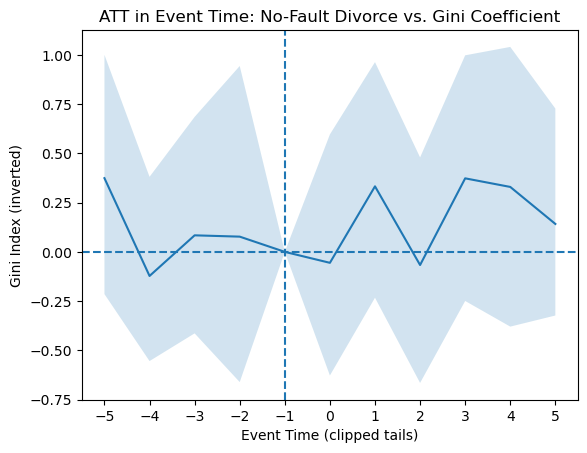

In [46]:
# plot ATT in Event Time

fig, ax = plt.subplots()

x_axis = event_time_att['event_time_binned']
y_axis = event_time_att['cell_mean']

plt.axvline(-1, linestyle='--')
plt.axhline(0, linestyle='--')

plt.plot(x_axis, y_axis)

#ci
x_axis_b = ci['e']
plt.fill_between(x_axis_b, ci['ci_low'], ci['ci_high'], alpha=0.2, label="95% CI")
plt.xlabel('Event Time (clipped tails)')
plt.xticks(x_axis)

plt.ylabel('Gini Index (inverted)')

plt.title("ATT in Event Time: No-Fault Divorce vs. Gini Coefficient")


plt.savefig('artifact/att_in_event_time.png', dpi=200, bbox_inches='tight')

plt.show()

# Event Study with Patsy Contrasts

In [73]:
# create new rel_year column and assign -1 value to NaN rows in rel_year (baseline)

df_es['rel_year_es'] = df_es['rel_year'].fillna(-1).clip(-5, 5)
df_es = df_es.rename(columns={'Treatment':'treatment'}) #rename treatment col to avoid clash with patsy 

df_es['Country'] = df_es['Country Name'].where(df_es['Country'].isna(), df_es['Country'])


In [75]:
# att with patsy formula

Y = "Gini_recon_hybrid"

# use rel_year_es instead of OnTreat
formula = f"{Y} ~ C(rel_year_es, Treatment(reference=-1)) + C(Country) + C(Year)"

results = smf.ols(formula=formula, data=df_es).fit(
    cov_type = 'cluster',
    cov_kwds = {"groups":df_es['Country']}
)

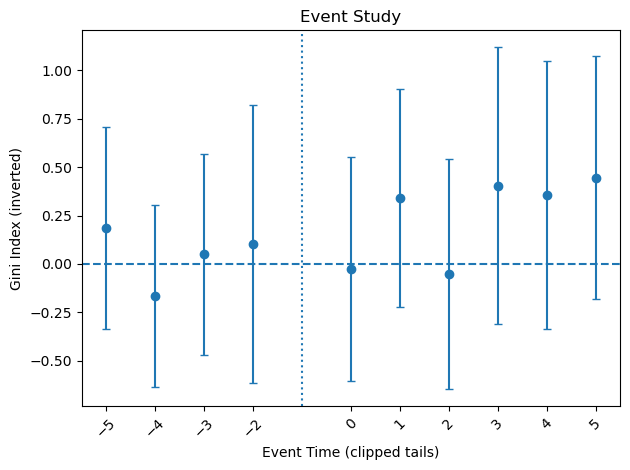

In [76]:
# event study plot

coefs = results.params.filter(like='rel_year_es')
ses = results.bse.filter(like='rel_year_es')

coefs_names = [int(float(s.split("T.")[1].rstrip(']'))) for s in coefs.index]

event_df = pd.DataFrame({
    'Relative Time': coefs_names,
    'Coefficient':coefs.values,
    'Standard Error':ses.values,
    'pvalue': results.pvalues.filter(like='rel_year_es'),
    'tvalue': results.tvalues.filter(like='rel_year_es')
})

event_df = event_df.sort_values(by='Relative Time', ascending=True)

event_df

# # plot the results

fig, ax = plt.subplots()
plt.axhline(0, linestyle='--')
plt.axvline(-1, linestyle=':')

plt.errorbar(
    x = event_df['Relative Time'], y = event_df['Coefficient'], yerr=1.96*event_df['Standard Error'],
    fmt='o', capsize=3
)
plt.xlabel('Event Time (clipped tails)')
plt.xticks(event_df['Relative Time'])
plt.ylabel('Gini Index (inverted)')
plt.title("Event Study")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('artifact/event_study_bar.png', dpi=200, bbox_inches='tight')
plt.show()

# Event Study with Manual Dummies

In [77]:
# repeat event study with manual dummies for validation and understanding

cats = [-1] + sorted(c for c in df_es['rel_year_es'].dropna().unique() if c != -1)

df_es['rel_year_es'] = pd.Categorical(df_es['rel_year_es'], categories=cats, ordered=True)

E = pd.get_dummies(df_es['rel_year_es'], drop_first=True, prefix='k')

e_names_term = " + ".join([f"Q('{c}')" for c in E.columns])

# fit model

results = smf.ols(
    f"Gini_recon_hybrid ~ 0 + {e_names_term} + C(Country) + C(Year)",
    data = df_es.assign(**E)
).fit(cov_type='cluster', cov_kwds={'groups':df_es['Country']})

In [78]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Gini_recon_hybrid   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 31 Jan 2026   Prob (F-statistic):                nan
Time:                        17:36:31   Log-Likelihood:                -14916.
No. Observations:                7750   AIC:                         3.022e+04
Df Residuals:                    7554   BIC:                         3.159e+04
Df Model:                         195                                         
Covariance Type:              cluster                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(Country)[Albania]                     69.8816      0.055   1262.153      0.000      69.773      69.990
C(Country)[Algeria]                     67.8474      0.055   1225.413      0.000      67.739      67.956
C(Country)[Argentina]                   56.2806      0.265    212.102      0.000      55.761      56.801
C(Country)[Armenia]                     69.1104      0.055   1248.224      0.000      69.002      69.219
C(Country)[Australia]                   67.8078      0.269    251.725      0.000      67.280      68.336
C(Country)[Austria]                     70.7690      0.267    265.372      0.000      70.246      71.292
C(Country)[Bangladesh]                  70.9591      0.055   1281.613      0.000      70.851      71.068
C(Country)[Belarus]                     73.8999      0.055   1334.729      0.000      73.791      74.008
C(Country)[Belgium]                     73.0241      0.261    280.281      0.000      72.514      73.535
C(Country)[Benin]                       60.1679      0.055   1086.712      0.000      60.059      60.276
C(Country)[Bolivia]                     51.5586      0.260    198.479      0.000      51.050      52.068
C(Country)[Bosnia and Herzegovina]      68.7802      0.265    259.465      0.000      68.261      69.300
C(Country)[Botswana]                    43.9028      0.271    161.784      0.000      43.371      44.435
C(Country)[Brazil]                      45.1663      0.262    172.376      0.000      44.653      45.680
C(Country)[Bulgaria]                    65.9494      0.261    252.211      0.000      65.437      66.462
C(Country)[Burkina Faso]                59.5208      0.055   1075.023      0.000      59.412      59.629
C(Country)[Burundi]                     64.7738      0.055   1169.900      0.000      64.665      64.882
C(Country)[Cameroon]                    58.0675      0.055   1048.775      0.000      57.959      58.176
C(Country)[Central African Republic]    48.3710      0.055    873.644      0.000      48.263      48.480
C(Country)[Chad]                        60.9723      0.055   1101.240      0.000      60.864      61.081
C(Country)[Chile]                       51.1624      0.259    197.196      0.000      50.654      51.671
C(Country)[China]                       63.7269      0.055   1150.992      0.000      63.618      63.835
C(Country)[Colombia]                    47.6322      0.280    170.065      0.000      47.083      48.181
C(Country)[Comoros]                     50.6104      0.055    914.090      0.000      50.502      50.719
C(Country)[Congo, Dem. Rep.]            57.5688      0.055   1039.768      0.000      57.460      57.677
C(Country)[Costa Rica]                  54.6299      0.055    986.687      0.000      54.521      54.738
C(Country)[Cote d'Ivoire]             

In [79]:
# inspect results

coefs = results.params.filter(like='k_')
ses = results.bse.filter(like='k_')
p_vals = results.pvalues.filter(like='k_')
t_vals = results.tvalues.filter(like='k_')

In [80]:
# view results

results_df = (
    pd.DataFrame(pd.concat([coefs, ses, p_vals, t_vals], axis=1))
    .rename(columns={0:'coefficient', 1:'se', 2:'pval', 3:'tval'})
)

results_df

,coefficient,se,pval,tval
Q('k_-5.0'),0.186633,0.266593,0.483885,0.700067
Q('k_-4.0'),-0.166572,0.238922,0.485690,-0.697180
Q('k_-3.0'),0.049794,0.264730,0.850805,0.188092
Q('k_-2.0'),0.101748,0.366072,0.781055,0.277944
Q('k_0.0'),-0.024170,0.294913,0.934681,-0.081957
Q('k_1.0'),0.338422,0.286943,0.238238,1.179403
Q('k_2.0'),-0.052183,0.302958,0.863244,-0.172246
Q('k_3.0'),0.403001,0.364310,0.268638,1.106205
Q('k_4.0'),0.356791,0.351849,0.310560,1.014047
Q('k_5.0'),0.445702,0.320379,0.164174,1.391171


In [81]:
event_df

,Relative Time,Coefficient,Standard Error,pvalue,tvalue
"C(rel_year_es, Treatment(reference=-1))[T.-5.0]",-5,0.186633,0.266593,0.483885,0.700067
"C(rel_year_es, Treatment(reference=-1))[T.-4.0]",-4,-0.166572,0.238922,0.485690,-0.697180
"C(rel_year_es, Treatment(reference=-1))[T.-3.0]",-3,0.049794,0.264730,0.850805,0.188092
"C(rel_year_es, Treatment(reference=-1))[T.-2.0]",-2,0.101748,0.366072,0.781055,0.277944
"C(rel_year_es, Treatment(reference=-1))[T.0.0]",0,-0.024170,0.294913,0.934681,-0.081957
"C(rel_year_es, Treatment(reference=-1))[T.1.0]",1,0.338422,0.286943,0.238238,1.179403
"C(rel_year_es, Treatment(reference=-1))[T.2.0]",2,-0.052183,0.302958,0.863244,-0.172246
"C(rel_year_es, Treatment(reference=-1))[T.3.0]",3,0.403001,0.364310,0.268638,1.106205
"C(rel_year_es, Treatment(reference=-1))[T.4.0]",4,0.356791,0.351849,0.310560,1.014047
"C(rel_year_es, Treatment(reference=-1))[T.5.0]",5,0.445702,0.320379,0.164174,1.391171


In [82]:
event_time_att

,event_time_binned,cell_mean,n_cells,n_country
0,-5.0,0.374114,1882,65
1,-4.0,-0.122239,65,65
2,-3.0,0.083966,65,65
3,-2.0,0.077317,66,66
4,-1.0,0.000000,65,65
5,0.0,-0.055573,64,64
6,1.0,0.332610,63,63
7,2.0,-0.066686,63,63
8,3.0,0.373202,63,63
9,4.0,0.329594,61,61


In [83]:
# reset indices for side-by-side concat
event_df = event_df.reset_index()
results_df = results_df.reset_index()

In [84]:
pd.concat([event_df, results_df], axis=1)

,index,Relative Time,Coefficient,Standard Error,pvalue,tvalue,index,coefficient,se,pval,tval
0,"C(rel_year_es, Treatment(reference=-1))[T.-5.0]",-5,0.186633,0.266593,0.483885,0.700067,Q('k_-5.0'),0.186633,0.266593,0.483885,0.700067
1,"C(rel_year_es, Treatment(reference=-1))[T.-4.0]",-4,-0.166572,0.238922,0.485690,-0.697180,Q('k_-4.0'),-0.166572,0.238922,0.485690,-0.697180
2,"C(rel_year_es, Treatment(reference=-1))[T.-3.0]",-3,0.049794,0.264730,0.850805,0.188092,Q('k_-3.0'),0.049794,0.264730,0.850805,0.188092
3,"C(rel_year_es, Treatment(reference=-1))[T.-2.0]",-2,0.101748,0.366072,0.781055,0.277944,Q('k_-2.0'),0.101748,0.366072,0.781055,0.277944
4,"C(rel_year_es, Treatment(reference=-1))[T.0.0]",0,-0.024170,0.294913,0.934681,-0.081957,Q('k_0.0'),-0.024170,0.294913,0.934681,-0.081957
5,"C(rel_year_es, Treatment(reference=-1))[T.1.0]",1,0.338422,0.286943,0.238238,1.179403,Q('k_1.0'),0.338422,0.286943,0.238238,1.179403
6,"C(rel_year_es, Treatment(reference=-1))[T.2.0]",2,-0.052183,0.302958,0.863244,-0.172246,Q('k_2.0'),-0.052183,0.302958,0.863244,-0.172246
7,"C(rel_year_es, Treatment(reference=-1))[T.3.0]",3,0.403001,0.364310,0.268638,1.106205,Q('k_3.0'),0.403001,0.364310,0.268638,1.106205
8,"C(rel_year_es, Treatment(reference=-1))[T.4.0]",4,0.356791,0.351849,0.310560,1.014047,Q('k_4.0'),0.356791,0.351849,0.310560,1.014047
9,"C(rel_year_es, Treatment(reference=-1))[T.5.0]",5,0.445702,0.320379,0.164174,1.391171,Q('k_5.0'),0.445702,0.320379,0.164174,1.391171


In [85]:
event_time_att

,event_time_binned,cell_mean,n_cells,n_country
0,-5.0,0.374114,1882,65
1,-4.0,-0.122239,65,65
2,-3.0,0.083966,65,65
3,-2.0,0.077317,66,66
4,-1.0,0.000000,65,65
5,0.0,-0.055573,64,64
6,1.0,0.332610,63,63
7,2.0,-0.066686,63,63
8,3.0,0.373202,63,63
9,4.0,0.329594,61,61


In [86]:
# final results table

event_time_att = (
    event_time_att.merge(
        event_df[['Relative Time','pvalue','tvalue','Standard Error']], 
        left_on='event_time_binned', right_on='Relative Time', how='left')
)
    
event_time_att

,event_time_binned,cell_mean,n_cells,n_country,Relative Time,pvalue,tvalue,Standard Error
0,-5.0,0.374114,1882,65,-5.0,0.483885,0.700067,0.266593
1,-4.0,-0.122239,65,65,-4.0,0.485690,-0.697180,0.238922
2,-3.0,0.083966,65,65,-3.0,0.850805,0.188092,0.264730
3,-2.0,0.077317,66,66,-2.0,0.781055,0.277944,0.366072
4,-1.0,0.000000,65,65,NaN,NaN,NaN,NaN
5,0.0,-0.055573,64,64,0.0,0.934681,-0.081957,0.294913
6,1.0,0.332610,63,63,1.0,0.238238,1.179403,0.286943
7,2.0,-0.066686,63,63,2.0,0.863244,-0.172246,0.302958
8,3.0,0.373202,63,63,3.0,0.268638,1.106205,0.364310
9,4.0,0.329594,61,61,4.0,0.310560,1.014047,0.351849


In [87]:
# add 95% ci col

low = round(event_time_att['cell_mean']-(1.96*event_time_att['Standard Error']), 2)
high = round(event_time_att['cell_mean']+(1.96*event_time_att['Standard Error']), 2)

event_time_att['95% CI'] = list(zip(low, high))

event_time_att

,event_time_binned,cell_mean,n_cells,n_country,Relative Time,pvalue,tvalue,Standard Error,95% CI
0,-5.0,0.374114,1882,65,-5.0,0.483885,0.700067,0.266593,"(-0.15, 0.9)"
1,-4.0,-0.122239,65,65,-4.0,0.485690,-0.697180,0.238922,"(-0.59, 0.35)"
2,-3.0,0.083966,65,65,-3.0,0.850805,0.188092,0.264730,"(-0.43, 0.6)"
3,-2.0,0.077317,66,66,-2.0,0.781055,0.277944,0.366072,"(-0.64, 0.79)"
4,-1.0,0.000000,65,65,NaN,NaN,NaN,NaN,"(nan, nan)"
5,0.0,-0.055573,64,64,0.0,0.934681,-0.081957,0.294913,"(-0.63, 0.52)"
6,1.0,0.332610,63,63,1.0,0.238238,1.179403,0.286943,"(-0.23, 0.9)"
7,2.0,-0.066686,63,63,2.0,0.863244,-0.172246,0.302958,"(-0.66, 0.53)"
8,3.0,0.373202,63,63,3.0,0.268638,1.106205,0.364310,"(-0.34, 1.09)"
9,4.0,0.329594,61,61,4.0,0.310560,1.014047,0.351849,"(-0.36, 1.02)"


In [88]:
# cross check against manual ci's

ci_check = event_time_att[['event_time_binned', '95% CI']].merge(ci, left_on='event_time_binned', right_on='e', how='left')
ci_check

,event_time_binned,95% CI,e,ci_low,ci_high
0,-5.0,"(-0.15, 0.9)",-5.0,-0.214333,1.000097
1,-4.0,"(-0.59, 0.35)",-4.0,-0.554220,0.380857
2,-3.0,"(-0.43, 0.6)",-3.0,-0.413586,0.685003
3,-2.0,"(-0.64, 0.79)",-2.0,-0.660873,0.943327
4,-1.0,"(nan, nan)",-1.0,0.000000,0.000000
5,0.0,"(-0.63, 0.52)",0.0,-0.627396,0.596147
6,1.0,"(-0.23, 0.9)",1.0,-0.232767,0.962990
7,2.0,"(-0.66, 0.53)",2.0,-0.665098,0.479468
8,3.0,"(-0.34, 1.09)",3.0,-0.249142,0.997543
9,4.0,"(-0.36, 1.02)",4.0,-0.379358,1.040177


In [89]:
# round table numbers

event_time_att_rounded = event_time_att.round(3)
    
event_time_att_rounded = event_time_att_rounded.rename(columns={
    'event_time_binned':'Event Time',
    'cell_mean':'Effect (ATT)',
    'n_cells':'Observations',
    'n_country':'Countries',
    'pvalue':'P-Value',
    'tvalue':'T-Value'
}
)



event_time_att_rounded


,Event Time,Effect (ATT),Observations,Countries,Relative Time,P-Value,T-Value,Standard Error,95% CI
0,-5.0,0.374,1882,65,-5.0,0.484,0.700,0.267,"(-0.15, 0.9)"
1,-4.0,-0.122,65,65,-4.0,0.486,-0.697,0.239,"(-0.59, 0.35)"
2,-3.0,0.084,65,65,-3.0,0.851,0.188,0.265,"(-0.43, 0.6)"
3,-2.0,0.077,66,66,-2.0,0.781,0.278,0.366,"(-0.64, 0.79)"
4,-1.0,0.000,65,65,NaN,NaN,NaN,NaN,"(nan, nan)"
5,0.0,-0.056,64,64,0.0,0.935,-0.082,0.295,"(-0.63, 0.52)"
6,1.0,0.333,63,63,1.0,0.238,1.179,0.287,"(-0.23, 0.9)"
7,2.0,-0.067,63,63,2.0,0.863,-0.172,0.303,"(-0.66, 0.53)"
8,3.0,0.373,63,63,3.0,0.269,1.106,0.364,"(-0.34, 1.09)"
9,4.0,0.330,61,61,4.0,0.311,1.014,0.352,"(-0.36, 1.02)"


In [90]:
# drope merge col & inspect

event_time_att_rounded = event_time_att_rounded.drop(columns=['Relative Time'])


In [91]:
#store table link and generate visual for GitHub readme

event_time_att_rounded.to_csv('artifact/event_time_table_rounded.csv', index=False)
print(event_time_att_rounded.to_markdown(index=False))

|   Event Time |   Effect (ATT) |   Observations |   Countries |   P-Value |   T-Value |   Standard Error | 95% CI        |
|-------------:|---------------:|---------------:|------------:|----------:|----------:|-----------------:|:--------------|
|           -5 |          0.374 |           1882 |          65 |     0.484 |     0.7   |            0.267 | (-0.15, 0.9)  |
|           -4 |         -0.122 |             65 |          65 |     0.486 |    -0.697 |            0.239 | (-0.59, 0.35) |
|           -3 |          0.084 |             65 |          65 |     0.851 |     0.188 |            0.265 | (-0.43, 0.6)  |
|           -2 |          0.077 |             66 |          66 |     0.781 |     0.278 |            0.366 | (-0.64, 0.79) |
|           -1 |          0     |             65 |          65 |   nan     |   nan     |          nan     | (nan, nan)    |
|            0 |         -0.056 |             64 |          64 |     0.935 |    -0.082 |            0.295 | (-0.63, 0.52) |
|       

# Conclusion

**Cohort Approach**



**Staggered Approach**

Two event times are notable: k = 1 year post (significant) and k = 5 (tail bin, marginal). Effects at k=1 year after treatment are considerably stronger than five years out. Note: Cluster robust CIs shown below have been validated against bootstrap pair CIs in table "ci_check"

|   Event Time |   Effect (ATT) |   Observations |   Countries |   P-Value |   T-Value |   Standard Error | 95% CI        |
|-------------:|---------------:|---------------:|------------:|----------:|----------:|-----------------:|:--------------|
|           -5 |          0.374 |           1882 |          65 |     0.484 |     0.7   |            0.267 | (-0.15, 0.9)  |
|           -4 |         -0.122 |             65 |          65 |     0.486 |    -0.697 |            0.239 | (-0.59, 0.35) |
|           -3 |          0.084 |             65 |          65 |     0.851 |     0.188 |            0.265 | (-0.43, 0.6)  |
|           -2 |          0.077 |             66 |          66 |     0.781 |     0.278 |            0.366 | (-0.64, 0.79) |
|           -1 |          0     |             65 |          65 |   nan     |   nan     |          nan     | (nan, nan)    |
|            0 |         -0.056 |             64 |          64 |     0.935 |    -0.082 |            0.295 | (-0.63, 0.52) |
|            1 |          0.333 |             63 |          63 |     0.238 |     1.179 |            0.287 | (-0.23, 0.9)  |
|            2 |         -0.067 |             63 |          63 |     0.863 |    -0.172 |            0.303 | (-0.66, 0.53) |
|            3 |          0.373 |             63 |          63 |     0.269 |     1.106 |            0.364 | (-0.34, 1.09) |
|            4 |          0.33  |             61 |          61 |     0.311 |     1.014 |            0.352 | (-0.36, 1.02) |
|            5 |          0.142 |           1635 |          60 |     0.164 |     1.391 |            0.32  | (-0.49, 0.77) |


Effects at k = 1 are stronger than at k = 5. The k = 5 bin pools all years ≥5 and is marginal (p ≈ 0.053); its calendar-year composition should be inspected. Because tail bins are data-rich but heterogeneous, I focus interpretation on k≤5 and treat tails as supportive context.

Further analysis of the calendar-year mix at significant event times and cohorts will help reconcile cohort and event-study views. Additional research into the nature of divorce over time would be critical in truly understanding its effects. 

At very least, this analysis suggests that further inquiry is warranted.